In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
from scipy import ndimage
import random
from tensorflow import keras
from tensorflow.keras import layers

2022-03-28 10:14:01.732242: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
with open('X_train.pickle', 'rb') as f:
    X_train = pickle.load(f)
with open('y_train.pickle', 'rb') as f:
    X_test = pickle.load(f)

In [3]:
print('X Train lenght: ', len(X_train))
print('X Test length: ', len(X_test))

X Train lenght:  918
X Test length:  393


In [4]:
rec_df = pd.read_csv('Rec_face.csv')

In [5]:
y_train = rec_df['Recognizable-Facial-Feature'][:len(X_train)]
y_test = rec_df['Recognizable-Facial-Feature'][len(X_train):]

In [6]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def test_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [7]:
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))

2022-03-28 10:14:12.507170: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-28 10:14:12.548938: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-03-28 10:14:12.548986: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-28 10:14:12.642448: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-03-28 10:14:12.642504: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-03-28 10:14:12.658095: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.

In [8]:
batch_size = 8
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
test_dataset = (
    test_loader.shuffle(len(X_test))
    .map(test_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (128, 128, 64, 1)


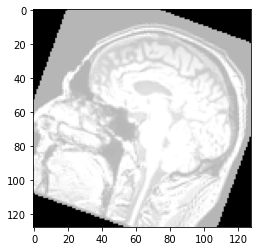

In [21]:
import numpy
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

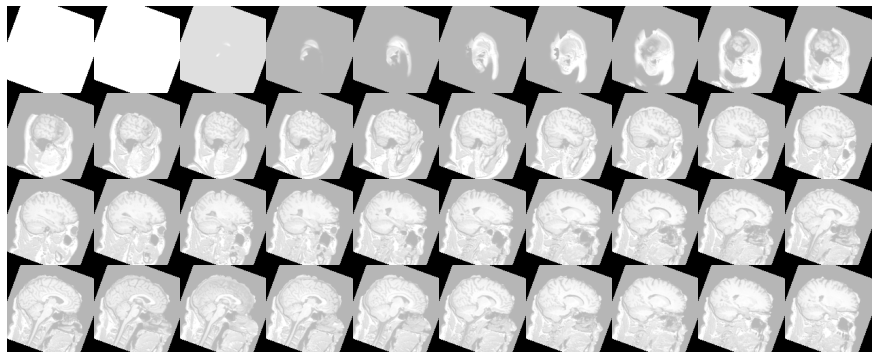

In [10]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

In [11]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""    
    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 64)    256   

In [12]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 10
model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/10


2022-03-28 10:14:31.548656: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-03-28 10:14:32.457224: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2022-03-28 10:14:33.313031: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-03-28 10:14:33.895306: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


115/115 [==============================] - 131s 1s/step - loss: 0.1333 - acc: 0.9597 - val_loss: 0.8247 - val_acc: 0.2494
Epoch 2/10
115/115 [==============================] - 126s 1s/step - loss: 0.0761 - acc: 0.9793 - val_loss: 0.2821 - val_acc: 0.7812
Epoch 3/10
115/115 [==============================] - 125s 1s/step - loss: 0.0585 - acc: 0.9847 - val_loss: 0.1873 - val_acc: 0.9796
Epoch 4/10
115/115 [==============================] - 125s 1s/step - loss: 0.0374 - acc: 0.9902 - val_loss: 0.2393 - val_acc: 0.9237
Epoch 5/10
115/115 [==============================] - 124s 1s/step - loss: 0.0684 - acc: 0.9793 - val_loss: 0.1236 - val_acc: 0.9822
Epoch 6/10
115/115 [==============================] - 124s 1s/step - loss: 0.0474 - acc: 0.9880 - val_loss: 0.0734 - val_acc: 0.9822
Epoch 7/10
115/115 [==============================] - 124s 1s/step - loss: 0.0445 - acc: 0.9869 - val_loss: 2.3852 - val_acc: 0.4173
Epoch 8/10
115/115 [==============================] - 125s 1s/step - loss: 0.050

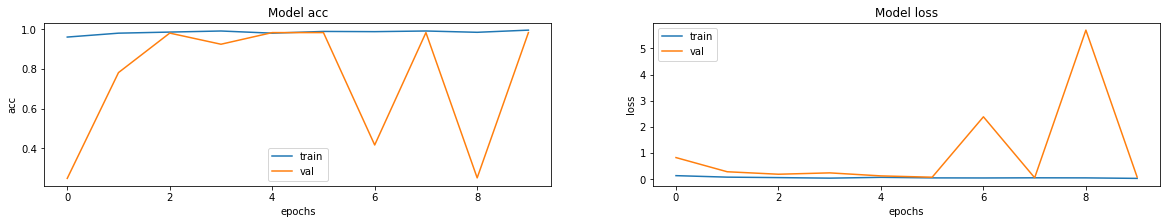

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [19]:
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(X_test[56], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 0.03 percent confident that CT scan is normal
This model is 99.97 percent confident that CT scan is abnormal
